# Drone Detect - A Project by Anu Bazarragchaa

This is a Google CoLab notebook of the Drone Detect project. Within this project, I will explore the audio data with and without drones visually as well as train ML models to classify the sounds correctly. For more information, please see the report. -Anu (NOTE: Still working on the report!!!)

## Step 0: Setting up your path.
If you've made a copy of this notebook, please upload the dataset from the link and upload your drive. Don't forget to mount your drive.✨👩‍💻

In [ ]:
# setting our path - change here if need be
data_dir = "/content/drive/MyDrive/DroneAudioDataset/Binary_Drone_Audio/"

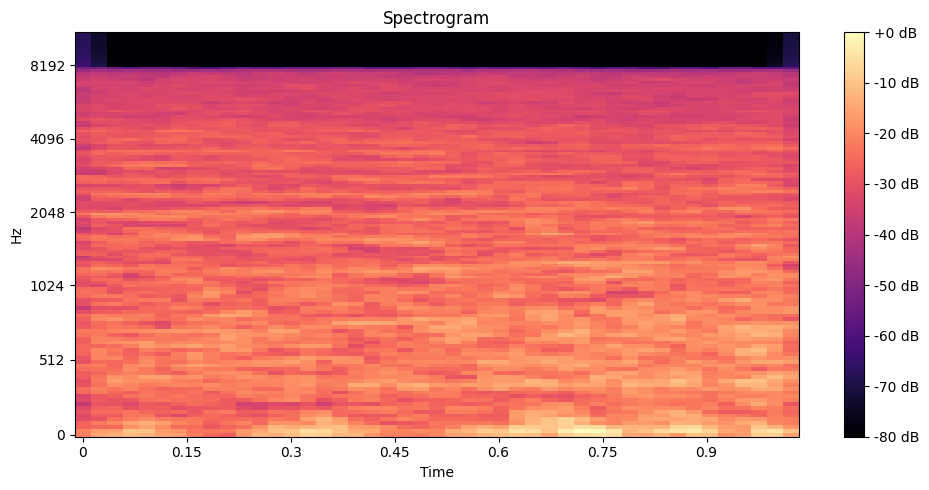

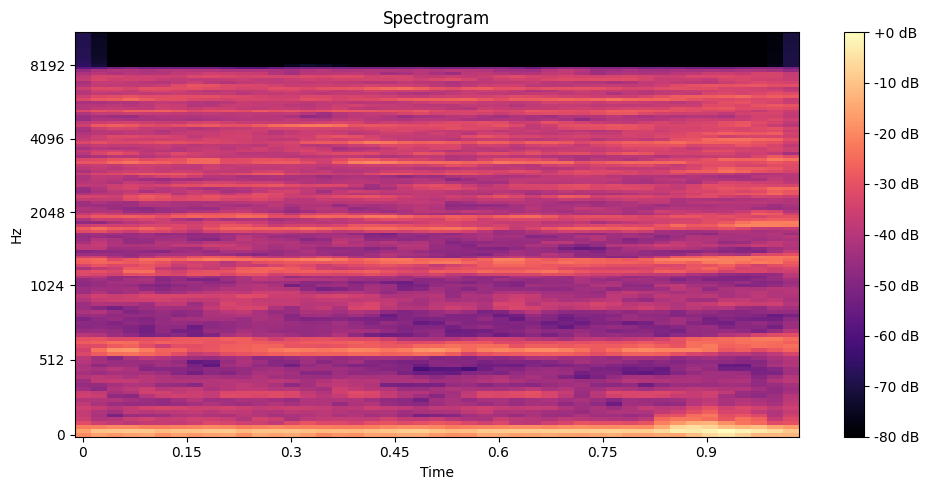

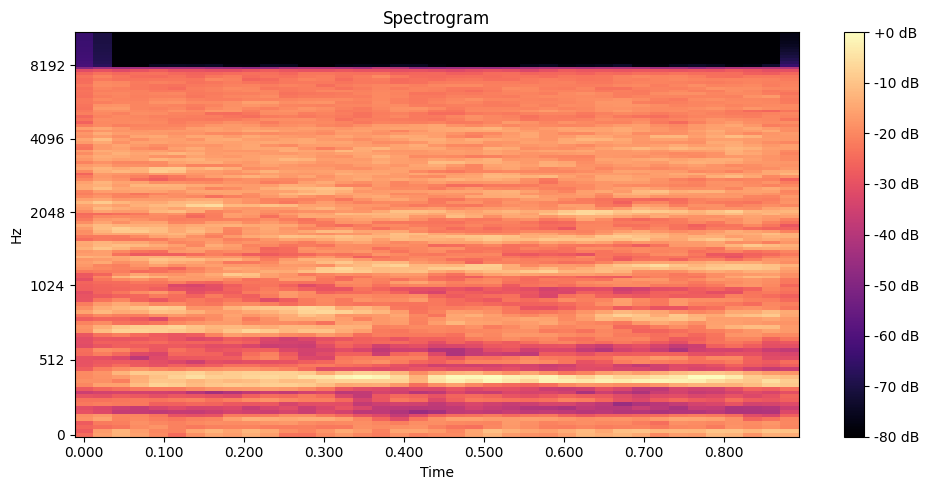

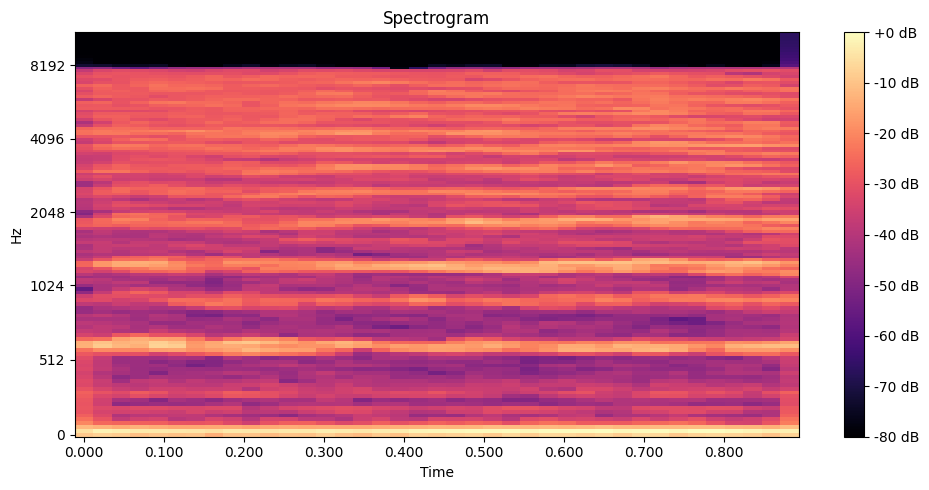

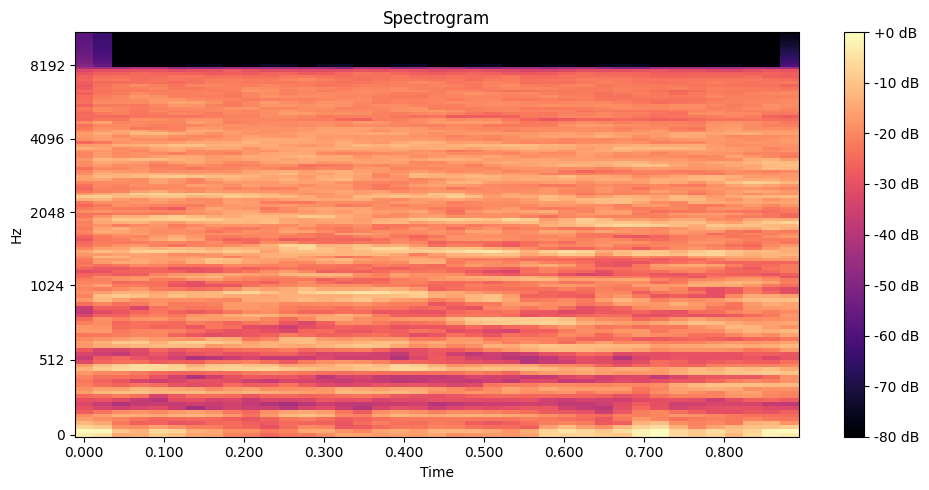

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np

#visualizing spectrograms for audio files
def visualize_spectrogram(audio_path):
    #load the files using librosa
    y, sr = librosa.load(audio_path)
    # generating spectros
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    #show the beautiful spectros
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

#let's visualize the audio files with drone sound. For the sake of time, we use 5 files.
yes_drone_dir = os.path.join(data_dir, "yes_drone")
yes_drone_files = [file for file in os.listdir(yes_drone_dir) if file.endswith('.wav')][:5]

for file in yes_drone_files:
    audio_path = os.path.join(yes_drone_dir, file)
    visualize_spectrogram(audio_path)


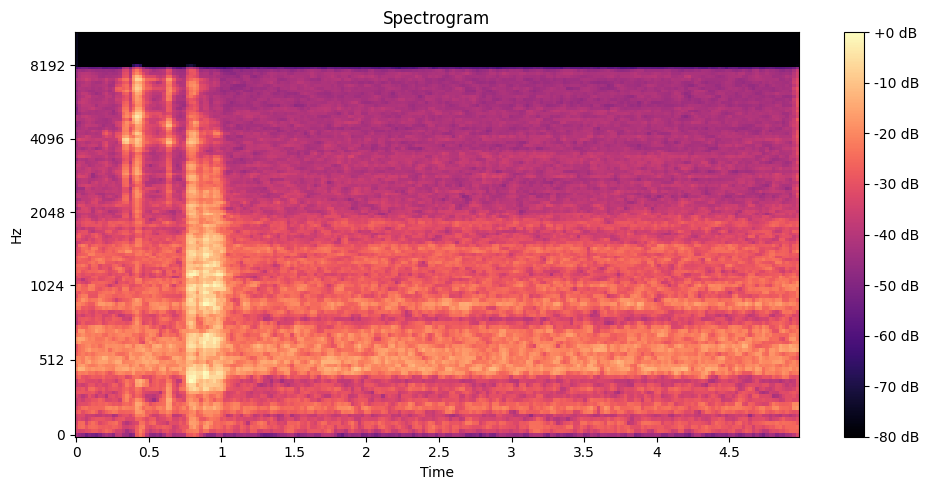

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1745
  warnings.warn(


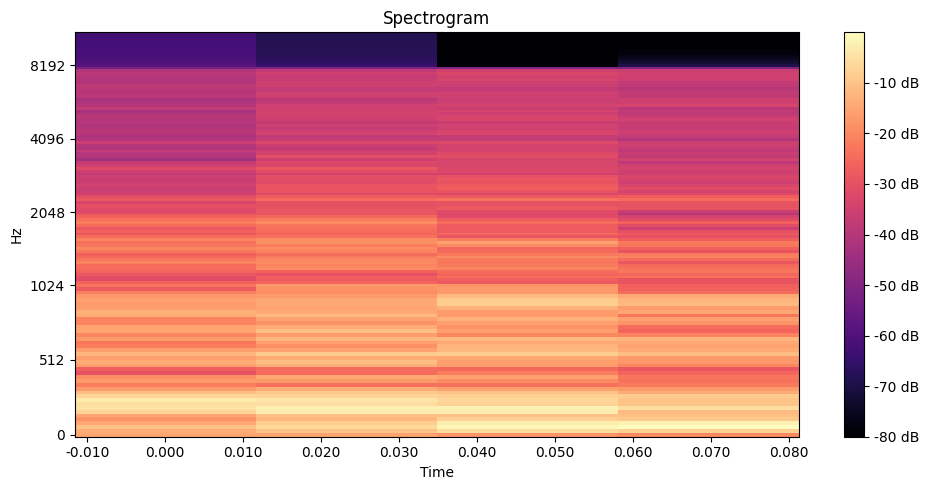

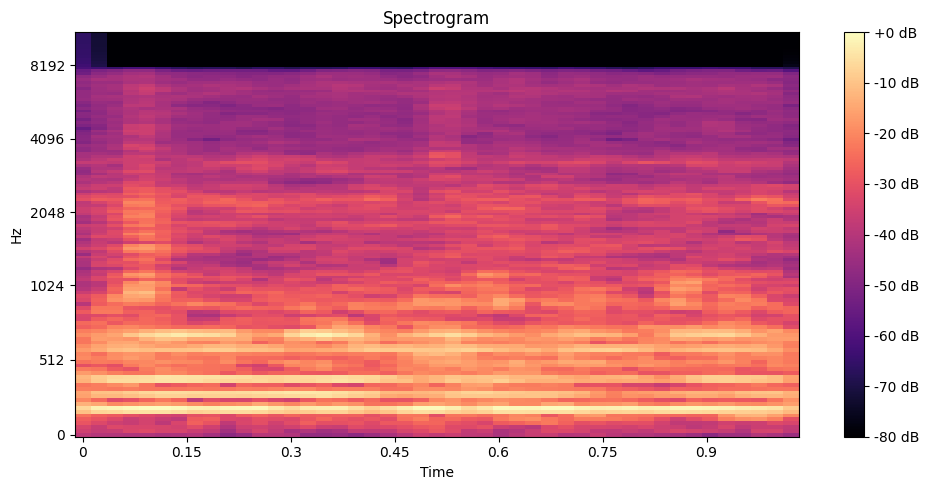

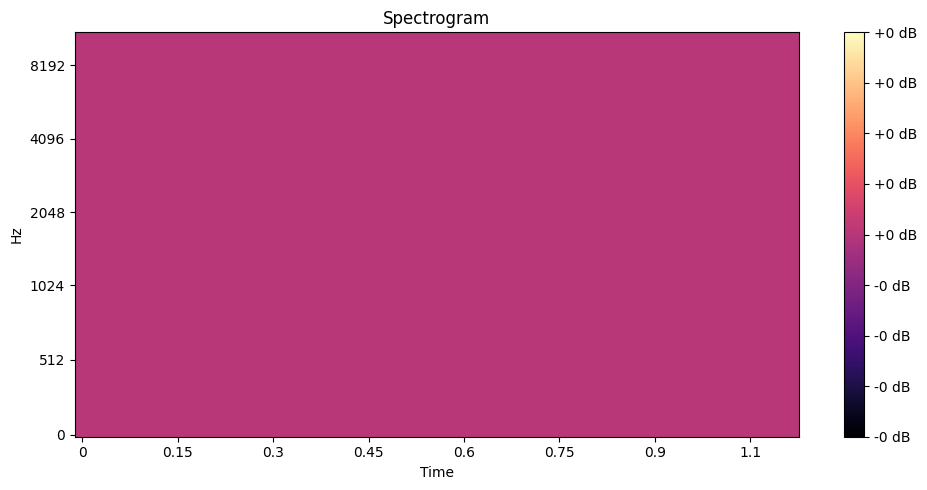

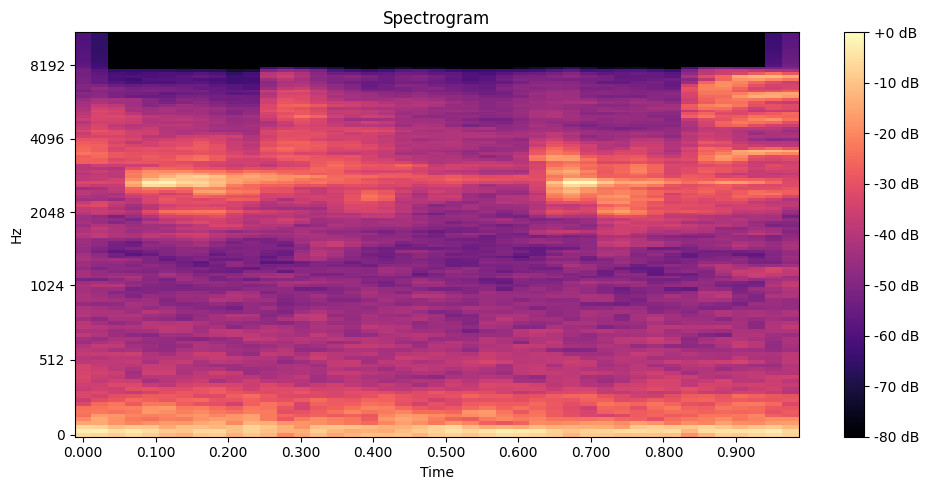

In [ ]:
#now let's visualize the non-drone audio.
no_drone_dir = os.path.join(data_dir, "unknown")
no_drone_files = [file for file in os.listdir(no_drone_dir) if file.endswith('.wav')][:5]
for file in no_drone_files:
    audio_path = os.path.join(no_drone_dir, file)
    visualize_spectrogram(audio_path)

In the publication, they created these files with background noise as well as silent audio files. You can see here that some of the files are inconsistent, while the ones with drone audio seem to follow a common trend. (https://www.researchgate.net/publication/332727775_Audio_Based_Drone_Detection_and_Identification_using_Deep_Learning)

## Step 2: Data preparation

In order to prepare our data, let's divide it 80:10:10 as mentioned in the second publication. This is a general step and an ideation how it should be done. (https://arxiv.org/abs/1711.07128)

In [ ]:
from sklearn.model_selection import train_test_split
import glob

drone_path = "/content/drive/MyDrive/DroneAudioDataset/Binary_Drone_Audio/yes_drone/*.wav"
unknown_path = "/content/drive/MyDrive/DroneAudioDataset/Binary_Drone_Audio/unknown/*.wav"

#fetching paths for drone sounds and unknown sounds using glob
drone_files = glob.glob(drone_path)
unknown_files = glob.glob(unknown_path)
print(f' The amount of drone files we have: {len(drone_files)}')
print(f' The amount of non-drone files we have: {len(unknown_files)}')

#creating labels where 1 stands for drone sounds, and 0 stands for unknown/non-drone
file_paths = drone_files + unknown_files
labels = [1] * len(drone_files) + [0] * len(unknown_files)

#split the dataset into train (80%), validation (10%), and test (10%)
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels, test_size=0.5, random_state=42)


 The amount of drone files we have: 1332
 The amount of non-drone files we have: 10372


## Step 3: PyTorch
Let's use PyTorch to carry out the rest of our analysis. (Because i haven't learned Keras yet lol) PyTorch has its own set of data objects called tensor, so with this code, we are translating it to something the torch can read and work with.

In [ ]:
import torch
from torch.utils.data import Dataset
import librosa
import numpy as np

class AudioDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        #loading the audio file using librosa
        audio_file = self.file_paths[idx]
        y, sr = librosa.load(audio_file)

        #extracting the Mel-spectrogram features
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        resized_spectrogram = np.resize(log_spectrogram, (1, 128, 128))  # Resize to a fixed shape

        #converting to PyTorch tensor
        spectrogram_tensor = torch.tensor(resized_spectrogram).float()

        label = torch.tensor(self.labels[idx]).long()

        return spectrogram_tensor, label

In [ ]:
from torch.utils.data import DataLoader

#data sets
train_dataset = AudioDataset(train_files, train_labels)
val_dataset = AudioDataset(val_files, val_labels)
test_dataset = AudioDataset(test_files, test_labels)

#data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

#check lengths - for the sake of time i've reduced the amount of files to the smallest batch available
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

5
1
1


CNN using PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: drone and non-drone

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)  # adjust this based on the input size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# initialize the model
model = AudioCNN()


In [ ]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")


Epoch [1/10], Loss: 24.53904082775116
Epoch [2/10], Loss: 1.3358262121677398
Epoch [3/10], Loss: 0.3554821938276291
Epoch [4/10], Loss: 0.17611056417226792
Epoch [5/10], Loss: 0.1281874194741249
Epoch [6/10], Loss: 0.08562685772776604
Epoch [7/10], Loss: 0.05575042068958282
Epoch [8/10], Loss: 0.0799635373055935
Epoch [9/10], Loss: 0.057057150080800055
Epoch [10/10], Loss: 0.028908106219023465


In [ ]:
#evaluation - for CNN
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 95.00%


RNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np



class SimpleAudioRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleAudioRNN, self).__init__()
        self.input_size = input_size  #input_size as an attribute! do not remove
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.input_size)  #reshape input
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  #for classification
        return out

#designing our model
input_size = 128  #input size based on the spectrogram shape
hidden_size = 64   #hidden state size of the RNN
num_classes = 2    #number of classes - (now it's drone and no drone)
model = SimpleAudioRNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

#evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Epoch [1/10], Loss: 0.7253944873809814
Epoch [2/10], Loss: 0.679262638092041
Epoch [3/10], Loss: 0.6660261392593384
Epoch [4/10], Loss: 0.6673685073852539
Epoch [5/10], Loss: 0.6435203671455383
Epoch [6/10], Loss: 0.6397416830062866
Epoch [7/10], Loss: 0.6423861503601074
Epoch [8/10], Loss: 0.6397003889083862
Epoch [9/10], Loss: 0.6402134299278259
Epoch [10/10], Loss: 0.640837299823761
Validation Accuracy: 80.00%


They also used CRNN in the publication

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np


class SimpleAudioCRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleAudioCRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))

        #reshape to match input size??
        x = x.view(x.size(0), x.size(1), -1)[:,:,:128]

        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  #use the output of the last time step for classification
        return out


#define your model, loss function, and optimizer
input_size = 128  #input size based on the spectrogram shape
hidden_size = 64   #hidden state size of the RNN
num_classes = 2    #number of classes (drone and no drone)
model = SimpleAudioCRNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

#evaluation on validation set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Epoch [1/10], Loss: 0.8257783889770508
Epoch [2/10], Loss: 0.7097904443740845
Epoch [3/10], Loss: 0.6666489839553833
Epoch [4/10], Loss: 0.6276205897331237
Epoch [5/10], Loss: 0.6031090617179871
Epoch [6/10], Loss: 0.5773175001144409
Epoch [7/10], Loss: 0.5320752024650574
Epoch [8/10], Loss: 0.48968249559402466
Epoch [9/10], Loss: 0.44417370557785035
Epoch [10/10], Loss: 0.4076096832752228
Validation Accuracy: 75.00%


So all in all, the CNN model's accuracy was at 95%. The RNN model was at 80% while the CRNN was at 75%.

Here goes the analysis!

The model's accuracy being at such vastly different levels helps us reflect on what went differently than that of the original publication and the [17]th publication the authors have quoted. The first thing that comes to mind, is of course, the data. There may have been issues with data preparation, such as the splitting might have been different from the original publication. In this project, we did not, in fact, use the 70%:15%:15% ratio for the training, validation and testing.

A deeper look into CNNs might suggest that they are particularly good at capturing spatial features in spectrogram-adjacent data, while RNNs are often sought out for sequential data analysis. The architecture and hyperparameters such as the number of layers in question, hidden units, learning rate, etc. could all have had a huge impact on performance.


In the publication they create CPU-Time, Accuracy, Precision, Recall and F-score evaluation metrics.
